<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/splprep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from numpy import arange, cos, linspace, pi, sin, random
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

# make ascending spiral in 3-space
t=linspace(0,1.75*2*pi,100)

x = sin(t)
y = cos(t)
z = t


# spline parameters
s=.00001 # smoothness parameter
k=3 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tck,u = splprep([x,y,z],s=s,k=k,nest=-1)

# evaluate spline, including interpolated points
xnew,ynew,znew = splev(linspace(0,1,400),tck)


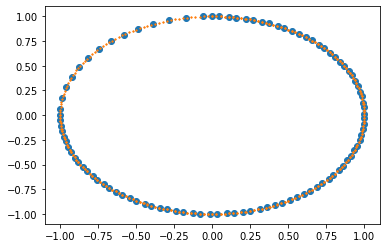

In [2]:
import matplotlib.pyplot as plt
ascatter = plt.scatter(x,y)
ascatter = plt.scatter(xnew,ynew,s=1)
plt.gca().add_artist(ascatter)


In [3]:
print(tck[0].shape)
print(tck[1][0].shape)
print(tck[1][1].shape)
print(tck[2])

(23,)
(19,)
(19,)
3


torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


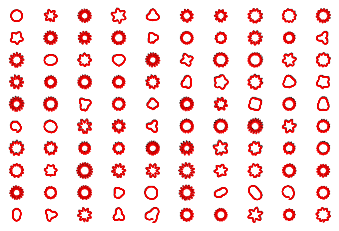

In [4]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        #a = 4.0*torch.sin(10.0*theta)
        #print(a.shape,torch.max(a))
        radii[i,:] += a
        #print(radii.shape, torch.max(radii))
    
    assert torch.min(radii)>0
    #print(radii.max(axis = 0)[0].shape)
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    #radii = torch.from_numpy(radii)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print(x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,x[l,:].type(torch.LongTensor),y[l,:].type(torch.LongTensor)]=1.0
        #points[l,:,0] = x[l,:]
        #points[l,:,1] = y[l,:]
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[0,:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            print("sample", sample.shape)
            pred = model(sample).view(1000,3)
            print('pred', pred.shape)
            predres = numpoints
            X = pred[:,0]
            Y = pred[:,1]
            
            s = [.001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            print("type",type(X))
            ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        #print(labels.shape)

        X = labels[:,0]
        Y = labels[:,1]
        #print(X.shape)
        #print(Y.shape)
            
        s = [.001 for x in range(numpoints)]
        #print(len(s))
        c = ['red' for x in range(numpoints)]
        #print(len(c))
        ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
        plt.gca().add_artist(ascatter)

class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length

    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        canvas = torch.reshape(canvas,(1,side,side))
        assert canvas.shape == (1,side,side)
        
        
        assert canvas.shape == (1,side,side)
        points = self.values["points"]
        points = points[idx,:]
        #points = points.unsqueeze(1)
        z = torch.zeros(numpoints,1)
        #print(z.shape)
        points = torch.cat([points,z], dim = 1)
        
        #print('points', points.shape)
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        #model.setBatchSize(batch_size = 1)
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)

dataset = DonutDataset(length = 100)
DonutDataset.displayCanvas('donut.png',dataset, model = None)


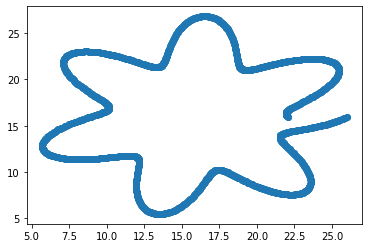

In [5]:
dataset[1][1].shape
x = dataset[1][1][:,0]
y = dataset[1][1][:,1]
ascatter = plt.scatter(x,y)
#ascatter = plt.scatter(xnew,ynew,s=1)
plt.gca().add_artist(ascatter)


In [6]:
t=np.linspace(0,1.75*2*pi,1000)
z = t

print(x.shape,y.shape,z.shape)
print(type(x),type(y),type(z))
# spline parameters
s=10 # smoothness parameter
k=3 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tck,u = splprep([x.cpu().numpy(),y.cpu().numpy(),z],s=s,k=k,nest=40)

# evaluate spline, including interpolated points
xnew,ynew,znew = splev(linspace(0,1,4000),tck)


torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The required storage space exceeds the available storage space.
Probable causes: data (x,y) size is too small or smoothing parameter
s is too small (fp>s).
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


(40,)
(36,)
(36,)
3


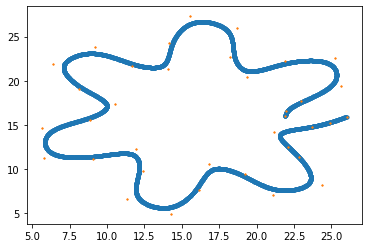

In [7]:
print(tck[0].shape)
print(tck[1][0].shape)
print(tck[1][1].shape)
print(tck[2])
ascatter = plt.scatter(xnew,ynew,s=10)
ascatter = plt.scatter(tck[1][0],tck[1][1],s=1)
plt.gca().add_artist(ascatter)


In [8]:

t=linspace(0,1.75*2*pi,100)

x = sin(t)
y = cos(t)
z = t

print(x.shape,y.shape,z.shape)
print(type(x))

# spline parameters
s=.00001 # smoothness parameter
k=3 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tck,u = splprep([x,y,z],s=s,k=k,nest=-1)

# evaluate spline, including interpolated points
xnew,ynew,znew = splev(linspace(0,1,400),tck)


(100,) (100,) (100,)
<class 'numpy.ndarray'>


torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
(35,)
(36,)
(36,)
3


/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The required storage space exceeds the available storage space.
Probable causes: data (x,y) size is too small or smoothing parameter
s is too small (fp>s).
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


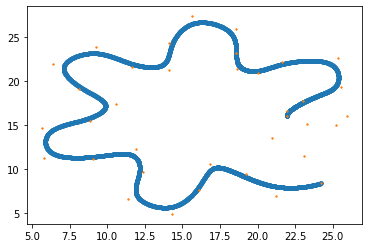

In [9]:
x = dataset[1][1][:,0]
y = dataset[1][1][:,1]
t=np.linspace(0,1,1000)
z = t

print(x.shape,y.shape,z.shape)
print(type(x),type(y),type(z))
# spline parameters
s=10 # smoothness parameter
k=3 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tck,u = splprep([x.cpu().numpy(),y.cpu().numpy(),z],s=s,k=k,nest=40)

# evaluate spline, including interpolated points
tck[0] = np.linspace(0,1,35)
tck[0][:4]=0
tck[0][-4:]=1
xnew,ynew,znew = splev(linspace(0,1,4000),tck)

print(tck[0].shape)
print(tck[1][0].shape)
print(tck[1][1].shape)
print(tck[2])
ascatter = plt.scatter(xnew,ynew,s=10)
ascatter = plt.scatter(tck[1][0],tck[1][1],s=1)
plt.gca().add_artist(ascatter)


In [10]:
  print(tck[0])

[0.         0.         0.         0.         0.11764706 0.14705882
 0.17647059 0.20588235 0.23529412 0.26470588 0.29411765 0.32352941
 0.35294118 0.38235294 0.41176471 0.44117647 0.47058824 0.5
 0.52941176 0.55882353 0.58823529 0.61764706 0.64705882 0.67647059
 0.70588235 0.73529412 0.76470588 0.79411765 0.82352941 0.85294118
 0.88235294 1.         1.         1.         1.        ]


torch.Size([1000]) torch.Size([1000]) (1000,)
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'numpy.ndarray'>
9 9
(13,)
(9,)
(9,)
3


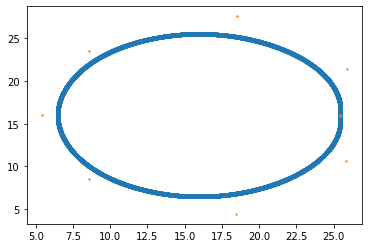

In [48]:
maxpoints = 0
minpoints = 100000
for xin,yin in dataset:
  x = yin[:,0]
  y = yin[:,1]
  t = np.linspace(0,1,1000)
  z = t

  print(x.shape,y.shape,z.shape)
  print(type(x),type(y),type(z))
  # spline parameters
  s=1 # smoothness parameter
  k=3 # spline order
  nest=-1 # estimate of number of knots needed (-1 = maximal)

  # find the knot points
  tck,u = splprep([x.cpu().numpy(),y.cpu().numpy(),z],s=s,k=k,nest=nest)
  print(len(tck[1][0]),len(tck[1][1]))
  # evaluate spline, including interpolated points
  #tck[0] = np.linspace(0,1,35)
  #tck[0][:4]=0
  #tck[0][-4:]=1
  xnew,ynew,znew = splev(linspace(0,1,4000),tck)

  print(tck[0].shape)
  maxpoints = max(maxpoints,tck[1][0].shape[0])
  minpoints = min(minpoints,tck[1][0].shape[0])
  print(tck[1][0].shape)
  print(tck[1][1].shape)
  print(tck[2])
  ascatter = plt.scatter(xnew,ynew,s=10)
  ascatter = plt.scatter(tck[1][0],tck[1][1],s=1)
  plt.gca().add_artist(ascatter)
  plt.show()
  break

In [12]:
print('minpoints',minpoints)
print('maxpoints',maxpoints)

minpoints 9
maxpoints 196


In [13]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_dim = 1*32*32
        self.control_pointsx =  nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Sigmoid()
        )
        self.control_pointsy =  nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Sigmoid()
        )
        self.spline_params =  nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Sigmoid()
        )

        self.maskc =  nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Sigmoid()
        )

        self.maskp =  nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Sigmoid()
        )

        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True)
        )

    def forward(self, x):
        
        x = x.squeeze()
        x = torch.flatten(x,start_dim=1)
        latent = self.mlp(x)
        return self.control_pointsx(latent),self.control_pointsy(latent),self.spline_params(latent),self.maskc(latent),self.maskp(latent)


In [14]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [15]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
loader_train = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [42]:
for xin,yin in loader_train:
  print('yin', yin.shape)
  out = model(xin)
  print('out', out[0].shape, out[1].shape, out[2].shape)
  x = yin[:,:,0]
  y = yin[:,:,1]
  t = np.array([np.linspace(0,1,1000) for i in range(64)])
  z = t
  # spline parameters
  s=1 # smoothness parameter
  k=3 # spline order
  nest=-1 # estimate of number of knots needed (-1 = maximal)

  print('xyz',x.shape, y.shape, t.shape)
  # find the knot points
  print(x[0,:].shape,y[0,:].shape)
  #tck_u = [splprep([x[i,:].cpu().numpy(),y[i,:].cpu().numpy(),z[i,:]],s=s,k=k,nest=nest) for i in range(64)]#64, 2, 3 
  tck,u = splprep([x[0,:].cpu().numpy(),y[0,:].cpu().numpy(),z[0,:]],s=s,k=k,nest=nest)
  #print(tck_u[0][1][0])#x
  #print(tck_u[0][1][1])#x
  print(tck[1][3].shape)
  break 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


yin torch.Size([64, 1000, 3])
out torch.Size([64, 1024]) torch.Size([64, 1024]) torch.Size([64, 1024])
xyz torch.Size([64, 1000]) torch.Size([64, 1000]) (64, 1000)
torch.Size([1000]) torch.Size([1000])


IndexError: ignored

In [ ]:
ascatter = plt.scatter(tck[1][0],tck[1][1],s=1)
